# 机器学习实验报告
## Lab1：K-Nearest Neighbor(KNN) Classification
* 姓名：周钰宸
* 学号：2111408
* 专业：信息安全
### 实验目的
### 实验要求：
题目：基于KNN 的手写数字识别 
实验条件：给定semeion手写数字数据集，给定kNN分类算法 
实验要求：
1. 基本要求：编程实现kNN算法；给出在不同k值（1，3，5）情况下，kNN算法对手写数字的识别精度（要求采用留一法）
2. 中级要求：与weka机器学习包中的kNN分类结果进行对比
3. 提高要求：将实验过程结果等图示展出
### 实验原理
   K最近邻（K-Nearest Neighbors，简称KNN）是一种常用的监督学习算法，主要用于分类和回归问题。它的基本原理可以概括为：如果一个样本在特征空间中的K个最相似（即特征空间中最邻近）的样本中的大多数属于某一个类别，则该样本也属于这个类别。KNN算法的核心思想是通过找出与目标样本最接近的K个训练样本，然后利用这K个样本的类别信息来对目标样本的类别进行判断。

 #### KNN算法

1. **距离度量**：
   在KNN中，样本间的距离度量通常使用欧式距离、曼哈顿距离、切比雪夫距离等。这些距离度量方法用于衡量样本特征空间中的相似度。

2. **选取K个最近邻**：
   给定一个新样本，计算该样本与训练集中所有样本的距离，然后选取与该样本距离最近的K个样本。

3. **多数表决**：
   根据选取的K个样本的类别信息，通过投票的方式决定新样本所属的类别。即，新样本归属于K个最近邻样本中出现最多的类别。

 #### 距离计算范数

1. **欧式距离**：
   欧式距离是最常用的距离度量，用于衡量样本在特征空间中的距离。实际上是计算测试集样本到训练集样本的距离时的2范数。

2. **曼哈顿距离**：
   曼哈顿距离又称为城市街区距离，用于计算样本点在特征空间中的距离。实际上是计算测试集样本到训练集样本的距离时的1范数。

3. **切比雪夫距离**：
   切比雪夫距离用于计算样本点在特征空间中的距离，它是各个坐标数值差的最大值。实际上是计算测试集样本到训练集样本的距离时的无穷范数。

这些距离度量方法在KNN中用于确定最近邻样本，进而进行多数表决来判断新样本的类别。

 #### 留一法
留一法（Leave-One-Out Cross-Validation，LOOCV）是一种交叉验证的方法，它确保在每次验证中只有一个样本被用作测试集，而所有其他样本都用于训练。这意味着对于一个数据集有`n`个样本，将会进行`n`次不重复的实验，每次实验中一个样本被保留作为测试，其余`n-1`个样本用于训练。

在KNN中，LOOCV的应用是评估KNN模型的性能。对于每个样本，我们将其作为测试集，用其他样本作为训练集，然后计算模型在测试集上的表现指标（如准确率、F1分数等）。最终，取所有实验的表现指标的平均值作为模型的性能评估。

这种方法的优点是每个样本都被用于测试，保证了测试样本的充分利用。然而，它的缺点是计算成本高，尤其是对于大型数据集。对于每个样本，需要训练 `n-1`次模型，这可能会导致非常高的计算开销。

### 实验流程一：数据预处理
#### 导入所需要的包

In [43]:
# !/usr/bin/env python
# -*- encoding: utf-8 -*-
"""
@Project ：PythonProject
@File    ：main.py
@IDE     ：PyCharm
@Author  ：ErwinZhou
@Date    ：2023/9/26 23:59
"""
import numpy as np
from collections import Counter
import os
import pickle
from tqdm import trange
import matplotlib.pyplot as plt
# ---初级要求---
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
# ---中级要求---
from PIL import Image
import albumentations as A
import cv2
from tensorflow import keras
from tensorflow.keras import datasets,models,layers
# ---高级要求---

#### 数据读取与转换

In [41]:
def Data2Mat(filepath):
    """
    @todo Import data and process it
    @param filepath: Entering path of the data
    @return pixelMat: a returning Matrix with all pixel value
    @return typeMat: a returning Matrix with an indicator of which digit it belongs to
    @return rows: size of data
    """
    file = open(filepath)
    xiaoyuan_data = file.readlines()
    rows = len(xiaoyuan_data)
    pixelMat = np.zeros((rows, 256), dtype=np.float64)  # 像素矩阵
    typeMat = np.zeros(rows)  # 数字类型的矩阵
    for i in range(rows):
        single_row = xiaoyuan_data[i]
        single_data = single_row.split()
        for j in range(256):  # 0-255列为特征值
            pixelMat[i][j] = single_data[j]

        for j in range(256, 266):  # 256-266为数据类别（one-hot编码）
            if single_data[j] == "1":  # 出现“1”的字符串类型，便可由one-hot编码直接求出
                typeMat[i] = j - 256

    return pixelMat, typeMat, rows

In [32]:
filepath = r"semeion.data"  # 字符串视为原始字符串，不对\进行转义
features, labels, size = Data2Mat(filepath) # 读取并处理数据
print(np.shape(features),np.shape(labels),size)

(1593, 256) (1593,) 1593


#### 归一化处理
实际上由于本次给定的数据`semeion.data`是0-1数据，因此归一化并没有实际意义，但这里写出来方便其它类型的pixel数据使用，作为通用的接口函数。

In [11]:
def normalization(mat):
    """
    @todo To prevent the model from being biased towards certain features due to differences in feature scales
    @param mat: without normalization
    @return: mat :with normalization
    """
    rows = mat.shape[0]
    cols = mat.shape[1]
    for i in range(rows):
        max_values = max(mat[i])
        min_values = min(mat[i])
        for j in range(cols):
            mat[i][j] = (mat[i][j] - min_values) / (max_values - min_values)
    return mat


#### 数据分布
   这里是因为考虑到`sklearn.model_selection`的`train_test_split`具有一个可选的参数为`stratify`，是用于实现分层抽样的。分层抽样是一种确保训练集和测试集中各类别样本比例相似的抽样方法。

   具体来说，将某一列的类别标签（例如分类问题中的目标变量）传递给`stratify`参数时`train_test_split`函数会确保在分割数据时，训练集和测试集中各类别的比例与整个数据集中的比例大致相同。这对于确保训练集和测试集能够代表整体数据的分布特别有用，尤其是在样本类别不平衡的情况下。
   
这样做可以帮助避免在测试集中出现某个类别样本过于稀缺的情况，从而保持了数据分布的一致性。

In [5]:
def data_distribution(data):
    """
    @todo Discover the distributive pattern of given data to judge if there is a need for the "stratify" argument
    @param data: given data
    @return: none
    """
    variance_val = np.var(data)  # variance
    std_deviation = np.std(data)  # std_variance
    print("Variance:", variance_val)
    print("Standard Deviation:", std_deviation)

#### 获取距离矩阵
留一法中由于要计算每个样本与其它所有样本的特征空间距离，为了后面在基础要求中方便使用，这里提前将距离矩阵`distances`计算出来，并保存在目录下，这样也可以节省时间只计算一次。

In [6]:
def Get_distance_matrix(features, Type, Is_dump):
    """
    @todo Calculate and dump the distances matrix which will be used in the Leave-One-Out Cross-Validation
    @param features: prerequisite needs to calculate the distances matrix
    @param Type: determining argument of which type of norm will be used
                 by default, Type=2 is used, which corresponds to the Euclidean distance.
    @param Is_dump: determining argument of the need to dump the file for later use
    @return: distances matrix
    """
    if os.path.isfile(f"D:\\Codes\\Machine Learning\\Lab01\\{Type}.dis"):  # 判断矩阵的结果文件是否存在
        return pickle.load(open(f"D:\\Codes\\Machine Learning\\Lab01\\{Type}.dis", 'rb'))  # 若存在则直接返回加载的文件

    sample_size = features.shape[0]

    distances = np.zeros((sample_size, sample_size), dtype=np.float64)  # 记录距离的矩阵

    for i in trange(sample_size):  # 调用numpy库的norm函数计算范数
        distances[i, :] = np.linalg.norm(features[i, :] - features, axis=1, ord=Type)

    if Is_dump:  # 将文件dump进目录下
        with open(f"D:\\Codes\\Machine Learning\\Lab01\\{Type}.dis", 'wb') as f:
            pickle.dump(distances, f)
        print("Dump!")
    return distances

### 实验流程二：基本要求
编程实现kNN算法；给出在不同k值（1，3，5）情况下，kNN算法对手写数字的识别精度（要求采用留一法）

In [7]:
def KNN_MNIST(features, labels, neighbors, Norm_type, Is_dump):
    """
    @todo Implementation of KNN algorithm to classify MNIST dataset 
    @param features: pixel data from MNIST(256)
    @param labels: label data from MNIST coding in one-hot(10)
    @param neighbors: K-Nearest of KNN algorithm
    @param Norm_type: type of norm using in distances matrix calculation, an argument for Get_distance_matrix
    @param Is_dump: an argument for Get_distance_matrix
    @return accRate: result of KNN classification on MNIST
    """
    sample_size = features.shape[0]
    distances = Get_distance_matrix(features, Norm_type, Is_dump)
    reslabels = []  # 储存最终结果
    # Leave-One-Out Cross-Validation，LOOCV
    for i in trange(sample_size):  # 使用留一法，依次取出每个样本
        ind_dis_concat = np.concatenate([np.arange(sample_size).reshape(-1, 1), distances[i].reshape(-1, 1)], axis=1)
        # ind_dis_concat:直接取出distances matrix矩阵的第i行即为所要，与索引数组进行拼接，形成2×sample_size的数组
        sorted_index = np.array(sorted(ind_dis_concat, key=lambda x: x[1]), dtype=np.int32)[:, 0]
        # sorted_index:直接调用sorted函数对distances和index的拼接结果按照distances进行升序排列，并最后切片取出第一列即排序好的索引
        labelCount = labels[sorted_index[1:neighbors + 1]]
        # labelCount:由于0号位置距离一定为distances=0即与自身，故忽视sorted_index[0]
        # 取1-neighbors+1一共K=neighbors个邻居
        counter = Counter(labelCount)  # 调用Counter计数
        prelabel = counter.most_common(1)[0][0]  # 统计出现最多的作为预测标签结果
        reslabels.append(prelabel)  # 将预测结果记录在reslabels中
    accurate = np.sum(np.array(reslabels) == np.array(labels))  # 正确次数由reslabels和labels对比结果直接计算
    accRate = accurate / sample_size  # 统计准确率
    print('K={0}，范数为{1}范数时，实现的KNN正确个数为：{2}  准确率为：{3}'.format(neighbors, Norm_type, accurate, accRate))
    return accRate

#### 实验结果
1. 读取数据
2. 对数据分布进行判断
3. 对数据进行归一化处理~~（实际上没有任何用处hhh）~~
4. **采用欧氏距离的KNN算法，K=1，3，5时进行测试，输出手写数字的识别精度**

In [12]:
filepath = r"semeion.data"  # 字符串视为原始字符串，不对\进行转义
features, labels, size = Data2Mat(filepath)  # 读取并处理数据
data_distribution(labels)
ideal_variance = ((9 ** 2) / 12)  # ideal_variance: (b-a+1)^2 - 1 / 12，其中a=0, b=9
ideal_std_deviation = np.sqrt(ideal_variance)  # ideal_std_variance
print("Ideal Variance:", ideal_variance)  # 输出理想的方差和均差，便于与实际的对比，来判断数据分布和是否需要使用strafify参数
print("Ideal Standard Deviation:", ideal_std_deviation)
features = normalization(features)  # 实际上没有任何用处
KNN_MNIST(features, labels, 1, 2, True)  # K=1
KNN_MNIST(features, labels, 3, 2, False)  # K=3
KNN_MNIST(features, labels, 5, 2, False)  # K=5

Variance: 8.238116461338821
Standard Deviation: 2.870211919238512
Ideal Variance: 6.75
Ideal Standard Deviation: 2.598076211353316


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 847.25it/s]


K=1，范数为2范数时，实现的KNN正确个数为：1461  准确率为：0.9171374764595104


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 855.85it/s]


K=3，范数为2范数时，实现的KNN正确个数为：1460  准确率为：0.9165097300690521


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 858.33it/s]

K=5，范数为2范数时，实现的KNN正确个数为：1456  准确率为：0.9139987445072191


0.9139987445072191

**结果分析**
1. 首先可以注意到数据分布的方差与理想方差很接近，证明数据分布较均衡。
2. 其次分析运行时间，因为距离矩阵的计算`Get_distance_matrix`内部使用了`np.linag.norm`，即利用了`numpy`库对矩阵运算的优化，才得到了较高的性能和较短的运算时间，在初期尝试时候用矩阵套循环就运行的性能极低。
3. 最重要的分析结果，采用留一法和欧氏距离，在`K=1,3,5`时候，发现准确率均在91%以上，较高的准确率验证了KNN算法的合理性，也证明了基础要求实现的非常成功。

**实验探究一：K值最优化与可视化结果分析**

采用不同的KNN的邻居neighbors的K值进行遍历，探索准确率最高的K值。选取范围为`K=1-40`，用可视化结果呈现，并找到准确率最高的K值。

100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 853.22it/s]


K=1，范数为2范数时，实现的KNN正确个数为：1461  准确率为：0.9171374764595104


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 858.49it/s]


K=2，范数为2范数时，实现的KNN正确个数为：1461  准确率为：0.9171374764595104


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 851.07it/s]


K=3，范数为2范数时，实现的KNN正确个数为：1460  准确率为：0.9165097300690521


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 838.89it/s]


K=4，范数为2范数时，实现的KNN正确个数为：1463  准确率为：0.9183929692404269


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 867.67it/s]


K=5，范数为2范数时，实现的KNN正确个数为：1456  准确率为：0.9139987445072191


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 863.57it/s]


K=6，范数为2范数时，实现的KNN正确个数为：1458  准确率为：0.9152542372881356


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 846.78it/s]


K=7，范数为2范数时，实现的KNN正确个数为：1470  准确率为：0.9227871939736346


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 820.43it/s]


K=8，范数为2范数时，实现的KNN正确个数为：1473  准确率为：0.9246704331450094


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 853.13it/s]


K=9，范数为2范数时，实现的KNN正确个数为：1472  准确率为：0.9240426867545511


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 861.95it/s]


K=10，范数为2范数时，实现的KNN正确个数为：1463  准确率为：0.9183929692404269


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 839.87it/s]


K=11，范数为2范数时，实现的KNN正确个数为：1461  准确率为：0.9171374764595104


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 859.33it/s]


K=12，范数为2范数时，实现的KNN正确个数为：1459  准确率为：0.9158819836785939


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 836.33it/s]


K=13，范数为2范数时，实现的KNN正确个数为：1458  准确率为：0.9152542372881356


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 838.36it/s]


K=14，范数为2范数时，实现的KNN正确个数为：1451  准确率为：0.9108600125549278


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 798.72it/s]


K=15，范数为2范数时，实现的KNN正确个数为：1444  准确率为：0.90646578782172


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 861.68it/s]


K=16，范数为2范数时，实现的KNN正确个数为：1447  准确率为：0.9083490269930948


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:02<00:00, 789.45it/s]


K=17，范数为2范数时，实现的KNN正确个数为：1441  准确率为：0.9045825486503453


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 844.81it/s]


K=18，范数为2范数时，实现的KNN正确个数为：1434  准确率为：0.9001883239171374


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 833.14it/s]


K=19，范数为2范数时，实现的KNN正确个数为：1435  准确率为：0.9008160703075957


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 863.64it/s]


K=20，范数为2范数时，实现的KNN正确个数为：1434  准确率为：0.9001883239171374


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 864.33it/s]


K=21，范数为2范数时，实现的KNN正确个数为：1439  准确率为：0.9033270558694287


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 860.30it/s]


K=22，范数为2范数时，实现的KNN正确个数为：1438  准确率为：0.9026993094789705


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 867.87it/s]


K=23，范数为2范数时，实现的KNN正确个数为：1438  准确率为：0.9026993094789705


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 864.76it/s]


K=24，范数为2范数时，实现的KNN正确个数为：1431  准确率为：0.8983050847457628


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 856.11it/s]


K=25，范数为2范数时，实现的KNN正确个数为：1428  准确率为：0.896421845574388


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 853.46it/s]


K=26，范数为2范数时，实现的KNN正确个数为：1430  准确率为：0.8976773383553045


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 867.35it/s]


K=27，范数为2范数时，实现的KNN正确个数为：1425  准确率为：0.8945386064030132


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 858.03it/s]


K=28，范数为2范数时，实现的KNN正确个数为：1416  准确率为：0.8888888888888888


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 859.77it/s]


K=29，范数为2范数时，实现的KNN正确个数为：1417  准确率为：0.8895166352793471


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 855.32it/s]


K=30，范数为2范数时，实现的KNN正确个数为：1420  准确率为：0.8913998744507219


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:02<00:00, 782.91it/s]


K=31，范数为2范数时，实现的KNN正确个数为：1419  准确率为：0.8907721280602636


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 813.63it/s]


K=32，范数为2范数时，实现的KNN正确个数为：1417  准确率为：0.8895166352793471


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 859.83it/s]


K=33，范数为2范数时，实现的KNN正确个数为：1420  准确率为：0.8913998744507219


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 860.36it/s]


K=34，范数为2范数时，实现的KNN正确个数为：1419  准确率为：0.8907721280602636


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 858.68it/s]


K=35，范数为2范数时，实现的KNN正确个数为：1422  准确率为：0.8926553672316384


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 855.17it/s]


K=36，范数为2范数时，实现的KNN正确个数为：1410  准确率为：0.8851224105461394


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 863.49it/s]


K=37，范数为2范数时，实现的KNN正确个数为：1414  准确率为：0.8876333961079724


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 856.88it/s]


K=38，范数为2范数时，实现的KNN正确个数为：1411  准确率为：0.8857501569365976


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 834.71it/s]


K=39，范数为2范数时，实现的KNN正确个数为：1401  准确率为：0.879472693032015


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 857.35it/s]


K=40，范数为2范数时，实现的KNN正确个数为：1399  准确率为：0.8782172002510985


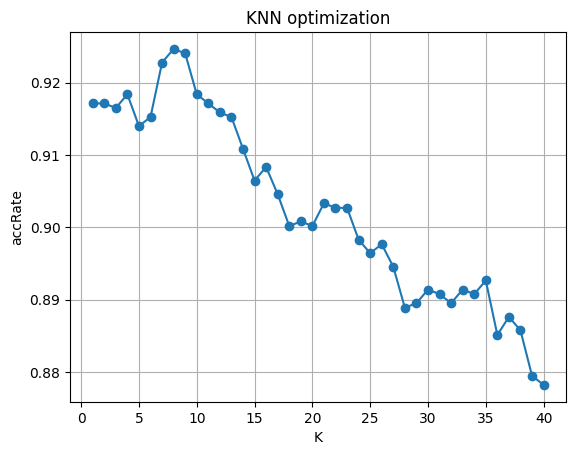

最大准确率对应的K值: 8, 最大准确率: 0.9246704331450094


In [33]:
accRates = []
for i in range(1, 41):  # K值范围从1到40
    accRates.append(KNN_MNIST(features, labels, i, 2, False))

K_values = list(range(1, 41))
# 绘制准确率折线图
plt.plot(K_values, accRates, marker='o')
plt.xlabel('K')
plt.ylabel('accRate')
plt.title('KNN optimization')
plt.grid(True)
plt.show()

max_accRate = max(accRates)  # K值范围从1到40
max_accRate_K = K_values[accRates.index(max_accRate)]
print(f"最大准确率对应的K值: {max_accRate_K}, 最大准确率: {max_accRate}")


**结果分析**

由上图可视化和分析结果可以发现，在采用欧几里得距离，并且遍历K值时发现：
1. 准确率在K=20之前都在90%之上，在K>20之后下降到90%以上，但最低的K=40也保持了约为87%的准确率，依然保持较高水平。
2. 准确率在K=10之前呈现较平稳与一段小幅上升趋势，在K=8时达到顶峰。之后准确率以越来越快的速率在不断下降，没有再次上升的趋势。
3. **`K=8`时准确率最高，约为92.46%。**
4. 无论是K值较小还是较大时，都并不能带来最高的准确率。**这证明K值的选择既不能过大，也不能过小。**

**实验探究二：不同的范数与可视化结果分析**

调整KNN算法中的距离参数即选取不同类型的Norm即np.linalg.norm中ord的不同取值。具体而言：
* ord=1：计算1范数（绝对值的和），即曼哈顿距离
* ord=2：计算2范数（向量的长度），即欧几里得距离
* ord=np.inf：计算无穷范数（取绝对值的最大值），即切比雪夫距离

由于在实验探究一中观察到了K在较大时候会出现急剧下降变化的趋势，为了能够试变化更明显，选择`K=1，100，...，1000`，试图找到其中的变化规律并比较三种范数。

100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 859.26it/s]


K=1，范数为1范数时，实现的KNN正确个数为：1461  准确率为：0.9171374764595104


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 870.25it/s]


K=1，范数为2范数时，实现的KNN正确个数为：1461  准确率为：0.9171374764595104


100%|████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 1085.42it/s]


K=1，范数为inf范数时，实现的KNN正确个数为：161  准确率为：0.10106716886377903


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 837.97it/s]


K=100，范数为1范数时，实现的KNN正确个数为：1323  准确率为：0.8305084745762712


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 852.42it/s]


K=100，范数为2范数时，实现的KNN正确个数为：1323  准确率为：0.8305084745762712


100%|████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 1054.43it/s]


K=100，范数为inf范数时，实现的KNN正确个数为：141  准确率为：0.08851224105461393


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 828.35it/s]


K=200，范数为1范数时，实现的KNN正确个数为：1252  准确率为：0.7859384808537351


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 822.46it/s]


K=200，范数为2范数时，实现的KNN正确个数为：1252  准确率为：0.7859384808537351


100%|████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 1034.28it/s]


K=200，范数为inf范数时，实现的KNN正确个数为：161  准确率为：0.10106716886377903


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:02<00:00, 771.09it/s]


K=300，范数为1范数时，实现的KNN正确个数为：1187  准确率为：0.7451349654739485


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:02<00:00, 782.48it/s]


K=300，范数为2范数时，实现的KNN正确个数为：1187  准确率为：0.7451349654739485


100%|████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 1034.97it/s]


K=300，范数为inf范数时，实现的KNN正确个数为：121  准确率为：0.07595731324544884


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 838.80it/s]


K=400，范数为1范数时，实现的KNN正确个数为：1128  准确率为：0.7080979284369114


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 831.32it/s]


K=400，范数为2范数时，实现的KNN正确个数为：1128  准确率为：0.7080979284369114


100%|████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 1003.03it/s]


K=400，范数为inf范数时，实现的KNN正确个数为：161  准确率为：0.10106716886377903


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 824.52it/s]


K=500，范数为1范数时，实现的KNN正确个数为：1080  准确率为：0.6779661016949152


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 811.85it/s]


K=500，范数为2范数时，实现的KNN正确个数为：1080  准确率为：0.6779661016949152


100%|████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 1031.84it/s]


K=500，范数为inf范数时，实现的KNN正确个数为：101  准确率为：0.06340238543628374


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 817.10it/s]


K=600，范数为1范数时，实现的KNN正确个数为：1038  准确率为：0.6516007532956686


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 804.87it/s]


K=600，范数为2范数时，实现的KNN正确个数为：1038  准确率为：0.6516007532956686


100%|████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 1023.85it/s]


K=600，范数为inf范数时，实现的KNN正确个数为：161  准确率为：0.10106716886377903


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 805.03it/s]


K=700，范数为1范数时，实现的KNN正确个数为：991  准确率为：0.6220966729441306


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 799.22it/s]


K=700，范数为2范数时，实现的KNN正确个数为：991  准确率为：0.6220966729441306


100%|████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 1003.66it/s]


K=700，范数为inf范数时，实现的KNN正确个数为：162  准确率为：0.1016949152542373


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 798.76it/s]


K=800，范数为1范数时，实现的KNN正确个数为：934  准确率为：0.5863151286880101


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:02<00:00, 786.27it/s]


K=800，范数为2范数时，实现的KNN正确个数为：934  准确率为：0.5863151286880101


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 994.49it/s]


K=800，范数为inf范数时，实现的KNN正确个数为：161  准确率为：0.10106716886377903


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:02<00:00, 774.21it/s]


K=900，范数为1范数时，实现的KNN正确个数为：895  准确率为：0.5618330194601381


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:02<00:00, 792.54it/s]


K=900，范数为2范数时，实现的KNN正确个数为：895  准确率为：0.5618330194601381


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 947.85it/s]


K=900，范数为inf范数时，实现的KNN正确个数为：40  准确率为：0.025109855618330193


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:02<00:00, 745.91it/s]


K=1000，范数为1范数时，实现的KNN正确个数为：839  准确率为：0.5266792215944758


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:02<00:00, 760.59it/s]


K=1000，范数为2范数时，实现的KNN正确个数为：839  准确率为：0.5266792215944758


100%|█████████████████████████████████████████████████████████████████████████████| 1593/1593 [00:01<00:00, 921.23it/s]


K=1000，范数为inf范数时，实现的KNN正确个数为：40  准确率为：0.025109855618330193


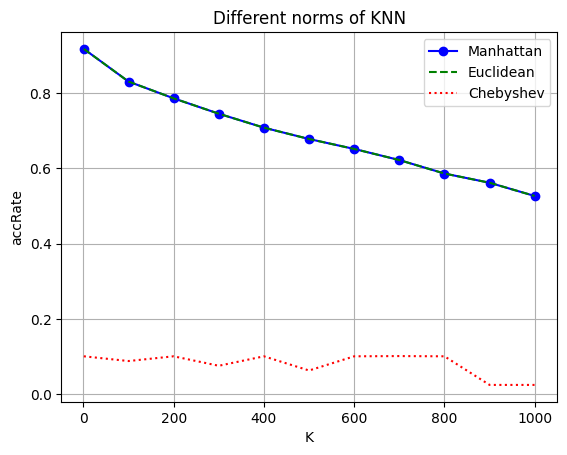

In [10]:
accRates_M = []  # 曼哈顿距离准确率
accRates_E = []  # 欧几里得距离准确率
accRates_C = []  # 切比雪夫距离准确率
for i in [1, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:#  K值步长100
    if i == 1:
        accRates_M.append(KNN_MNIST(features, labels, i, 1, True))
        accRates_E.append(KNN_MNIST(features, labels, i, 2, True))
        accRates_C.append(KNN_MNIST(features, labels, i, np.inf, True))
    else:
        
        accRates_M.append(KNN_MNIST(features, labels, i, 1, False))
        accRates_E.append(KNN_MNIST(features, labels, i, 2, False))
        accRates_C.append(KNN_MNIST(features, labels, i, np.inf, False))
    
K_values = [1, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
# 绘制折线图
plt.plot(K_values, accRates_M, label='Manhattan', color='blue', marker='o')
plt.plot(K_values, accRates_E, label='Euclidean', color='green', linestyle='--')
plt.plot(K_values, accRates_C, label='Chebyshev', color='red', linestyle=':')
plt.xlabel('K')
plt.ylabel('accRate')
plt.title('Different norms of KNN')
plt.legend()  # 显示图例
plt.grid(True)
plt.show()


**结果分析**

1. 可以发现，对于1范数和2范数即曼哈顿距离和欧几里得距离来说，K值的变化带来的KNN分类准确率**没有任何差别**。简单推测，这很可能是由于算法的简单性和像素数据的0-1二值表示法带来的必然结果。如果为真实的像素数据图片，不同的范数应该会带来不同的结果。
2. 还可以发现，与前两种范数对比，**无穷范数即切比雪夫距离带来的KNN分类准确率很低**。并且随着K值增大，虽然准确率呈现了时上时下的波动趋势，但仍然处于较低水平。
3. 最后还可以注意到，无论是哪种范数，在K值较大时，都呈现了明显的下降趋势并且在`K=1000`时准确率都达到了最低的水平，证明了K值不能选择过大。

### 实验流程三：中级要求
与sklearn或者weka等机器学习包中的kNN分类结果进行对比

这里选择使用`sklearn.neighbors`的`KNeighborsClassifier`来实现封装好的KNN进行对比。

In [36]:
def KNN_MNIST_sklearn(features, labels, neighbors, Norm_type, test_proportion=0.2, cross_validation=10):
    """
    @todo Implementation of KNN algorithm using sklearn package
    @param features: pixel data from MNIST(256)
    @param labels: label data from MNIST coding in one-hot(10)
    @param neighbors: K-Nearest of KNN algorithm
    @param Norm_type: type of norm using in KNeighborsClassifier to measure distances
    @param test_proportion: split proportion in train_test_split
    @return result from cross validation of KNN
    """
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_proportion)
    # 将原数据集按照比例划分为训练集和测试集，默认比例为8:2
    sklearn_KNN = KNeighborsClassifier(n_neighbors=neighbors, weights='uniform', algorithm='auto', leaf_size=30,
                                       p=Norm_type)
    # 调用sklearn库函数KNeighborsClassifier，这里传入可变参数neighbors，
    sklearn_KNN.fit(X_train, y_train.ravel())  # 模型训练，使用ravel函数将列向量的标签集改为行向量
    validation_scores = cross_val_score(sklearn_KNN, features, labels.ravel(), cv=cross_validation, scoring='accuracy')
    # 交叉验证：cv为交叉验证的折数，默认为10折交叉验证
    # scoring为评估指标，这里是准确率。在每次交叉验证后，会得到一个准确率，最终会返回这多次交叉验证的准确率。
    print(
        'k={0}，范数为{1}范数，test_proportion为{2}，cross_validation={3}时，sklearn的KNN所得准确率为{4}，交叉验证的准确率为{5}'.format(
            neighbors, Norm_type, test_proportion, cross_validation, sklearn_KNN.score(X_test, y_test),
            validation_scores.mean()))
    # 输出KNN的neighbors值，范数类型，test_size，交叉检验折数确定时，给定测试数据和标签的平均精度和交叉检验精度
    return validation_scores.mean()

优先测试sklearn的KNN在`K=1,3,5`时的结果。**由于之前通过`data_distribution`函数已经判断过数据的分布较为均衡，因此`train_test_split`并未加入参数`stratify`。同时令`test_proportion`和`cross_validation`都分别为默认最常用的0.2和10。**

In [37]:
KNN_MNIST_sklearn(features, labels, 1, 2, 0.2, 10)
KNN_MNIST_sklearn(features, labels, 3, 2, 0.2, 10)
KNN_MNIST_sklearn(features, labels, 5, 2, 0.2, 10)

k=1，范数为2范数，test_proportion为0.2，cross_validation=10时，sklearn的KNN所得准确率为0.9059561128526645，交叉验证的准确率为0.9171501572327043
k=3，范数为2范数，test_proportion为0.2，cross_validation=10时，sklearn的KNN所得准确率为0.9247648902821317，交叉验证的准确率为0.9039661949685535
k=5，范数为2范数，test_proportion为0.2，cross_validation=10时，sklearn的KNN所得准确率为0.896551724137931，交叉验证的准确率为0.9033333333333333


0.9033333333333333

**结果分析**
1. 首先可以看到，对于sklearn的KNN，在`K=1,3,5`时，交叉验证的准确率最高达到91%，而之前底层实现的KNN算法在`K=1,3,5`时准确率最低也能达到91%。
2. 其次可以注意到，对于sklearn的KNN，其代码量相比于底层的实现有了很大程度的简化，仅需简单的传入参数到接口函数便可以实现。并且运行速度更快，性能更强。

这样的结果，**初步证明了底层实现的KNN分类结果要轻微优于sklearn的KNN，但是代码量和实现难度要更大一些，并且运行性能相对较慢。**

**实验探究三：sklearn中KNN不同的K值及可视化结果分析对比**

   与底层实现的KNN一样，这里对sklearn的KNN的邻居neighbors的K值进行遍历，探索准确率最高的K值。选取范围为`K=1-40`，找到最大的准确率的K值后，将底层实现的KNN和sklearn的KNN进行可视化结果对比，进一步分析和对比。
   
   同时保证两种实现方式都采用欧几里得距离，即`Norm_type=2`来控制变量。对于sklearn的KNN，令`test_proportion`和`cross_validation`都分别为默认最常用的0.2和10。

k=1，范数为2范数，test_proportion为0.2，cross_validation=10时，sklearn的KNN所得准确率为0.9028213166144201，交叉验证的准确率为0.9171501572327043
k=2，范数为2范数，test_proportion为0.2，cross_validation=10时，sklearn的KNN所得准确率为0.8463949843260188，交叉验证的准确率为0.8832665094339622
k=3，范数为2范数，test_proportion为0.2，cross_validation=10时，sklearn的KNN所得准确率为0.9090909090909091，交叉验证的准确率为0.9039661949685535
k=4，范数为2范数，test_proportion为0.2，cross_validation=10时，sklearn的KNN所得准确率为0.8871473354231975，交叉验证的准确率为0.9058529874213835
k=5，范数为2范数，test_proportion为0.2，cross_validation=10时，sklearn的KNN所得准确率为0.8808777429467085，交叉验证的准确率为0.9033333333333333
k=6，范数为2范数，test_proportion为0.2，cross_validation=10时，sklearn的KNN所得准确率为0.9028213166144201，交叉验证的准确率为0.9064622641509434
k=7，范数为2范数，test_proportion为0.2，cross_validation=10时，sklearn的KNN所得准确率为0.896551724137931，交叉验证的准确率为0.9064779874213837
k=8，范数为2范数，test_proportion为0.2，cross_validation=10时，sklearn的KNN所得准确率为0.9310344827586207，交叉验证的准确率为0.9052004716981132
k=9，范数为2范数，test_proportion为0.2，cross_validation=10时，sklearn的KNN所得准确率为0.90

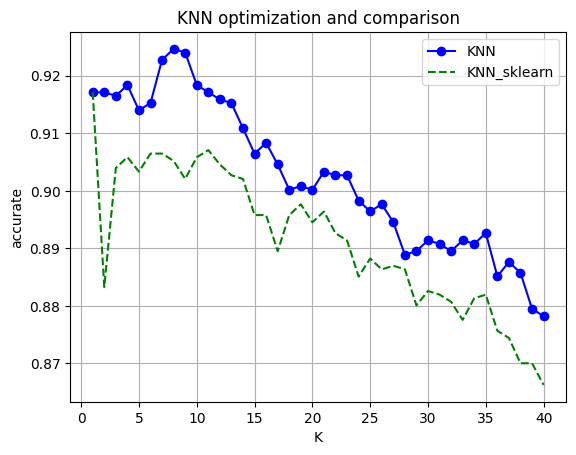

对于底层实现KNN的accRates，最大准确率对应的K值: 8, 最大准确率: 0.9246704331450094 

对于sklearn的KNN的accRates，当test_proportion=0.2，最大准确率对应的K值: 1, 最大准确率: 0.9171501572327043 


In [38]:
accRates_sklearn = []
for i in range(1, 41):
    accRates_sklearn.append(KNN_MNIST_sklearn(features, labels, i, 2, 0.2, 10))
K_values = list(range(1, 41))


# 绘制折线图
plt.plot(K_values, accRates, label='KNN', color='blue', marker='o')
plt.plot(K_values, accRates_sklearn, label='KNN_sklearn', color='green', linestyle='--')
plt.xlabel('K')
plt.ylabel('accurate')
plt.title('KNN optimization and comparison')
plt.legend()  # 显示图例
plt.grid(True)
plt.show()

max_accRate_sklearn = max(accRates_sklearn)  # K值范围从1到40
max_accRate_sklearn_K = K_values[accRates_sklearn.index(max_accRate_sklearn)]
print('对于底层实现KNN的accRates，最大准确率对应的K值: {0}, 最大准确率: {1} \n'.format(max_accRate_K, max_accRate))
print('对于sklearn的KNN的accRates，当test_proportion={0}，最大准确率对应的K值: {1}, 最大准确率: {2} '.format(0.2,
                                                                                                           max_accRate_sklearn_K,
                                                                                                           max_accRate_sklearn))

**结果分析**
1. 整体来看，底层实现的KNN的折线图始终高于sklearn的KNN折线图，体现了前者的分类准确率要优于后者。
2. 对于sklearn的KNN，其最大的K折检验的准确率出现在`K=1`时早于底层实现的KNN，并且最大准确率约为91.71%也低于92.46%的底层KNN准确率。
3. 同时二种实现方式可以发现，在K值较大时KNN的分类结果都较差，呈现明显的下降趋势。同时对于sklearn的KNN，其在`K=1`之后有个明显的下降，而`K=2`之后又有个较快的提升，于`K=2`时达到了最低。这个现象可能是由于**预测结果会对近邻的样本点⼗分敏感**造成的突变，有待进一步探究。

**总而言之，实验探究结果进一步证明了底层采用留一法实现的KNN的分类结果要全面优于sklearn的KNN算法**。初步推测这很可能和**留一法以及test_proportion的选取**有关，有待进一步探索总结发现规律。

### 实验流程四：提高要求
采用旋转等手段对原始数据进行处理，扩增数据量，采用CNN或其他深度学习方法实现手写体识别。

**数据处理与增强**
1. `PIL`：它提供了广泛的图像处理功能，包括图像打开、保存、裁剪、缩放、旋转、颜色调整等。这里使用**PIL包来将数组转换为图像对象。**
2. `OpenCV`：OpenCV是一个广泛使用的开源计算机视觉和机器学习软件库。**这里使用OpenCV用来读取图像后辅助Albumentations进行数据增强。**
3. `Albumentations`：基于Python的图像增强库，用于快速、灵活地进行图像增强。它支持各种图像处理任务，包括旋转、缩放、剪裁、翻转、色彩调整等。Albumentations特别适用于在深度学习中进行数据增强，以提高模型的泛化能力。**基于Albumentations实现了图像的360°旋转（以15°为单位），水平翻转和随机亮度及对比度调整**。

**总的来说，通过图像旋转、水平翻转和随机亮度以及对比度调整的方式实现了对原始数据的处理，将数据量扩增到了将近155倍。**


In [44]:
def image_augmentation(image, angle):
    """
    @todo Image Augmentation using PIL, Albumentations and OpenCV
    @param image: input image which is every single row of features in MNIST case
    @param angle: Albumentations rotation angles
    @return augmentation_image_np: numpy matrix of the augmented image
    """
    image_pil = Image.fromarray(image.reshape(16, 16).astype('uint8'), mode='L')
    # 创建一个PIL图像对象，将处理后的数组转换为图像对象
    # 将数组中的数据类型转换为无符号8位整数
    # 图像的模式为灰度图像（每个像素用一个8位整数表示）
    image_pil.save("temp.jpg")  # 暂时保存下来为了后续使用albumentations包进行数据增强
    # Declare an augmentation pipeline
    transform = A.Compose([
        A.Rotate(limit=(angle, angle), p=1.0),  # 旋转图像，固定旋转角度为angle，且应用于全部图像
        A.RandomCrop(width=16, height=16),  # 随机裁剪。图像会被随机裁剪成指定宽度和高度
        A.HorizontalFlip(p=0.5),  # 水平翻转。图像有50%的概率被水平翻转
        A.RandomBrightnessContrast(p=0.2),  # 随机亮度和对比度调整。图像有20%的概率会进行随机亮度和对比度调整
    ])
    image_al = cv2.imread("temp.jpg", cv2.IMREAD_GRAYSCALE)  # 通过OpenCV读取数据
    # Augment an image图像增强
    transformed = transform(image=image_al)
    transformed_image = transformed['image']
    file_path = "temp.jpg"  # 将文件删除
    try:
        os.remove(file_path)
    except OSError as e:
        print(f"Error: {e.filename} - {e.strerror}")
    augmentation_image_np = np.array(transformed_image).reshape(256)  # 将增强后的图像重新转化为数组的形式返回
    return augmentation_image_np

In [45]:
def data_augmentation(filepath):
    """
    @param filepath: Entering path of the data
    @return augmented_pixelMat: a returning Matrix with augmented pixel value
    @return augmented_typeMat: a returning Matrix with an augmented indicator
    @return rows: size of augmented data
    """
    file = open(filepath)
    xiaoyuan_data = file.readlines()
    rows = len(xiaoyuan_data)
    pixelMat = np.zeros((rows, 256), dtype=np.float64)  # 像素矩阵
    typeMat = np.zeros(rows)  # 数字类型的矩阵
    augmented_pixelMat = np.zeros((rows * 25, 256), dtype=np.float64)  # 增强后的像素矩阵
    augmented_typeMat = np.zeros((rows * 25))  # 增强后的数字类型矩阵
    for i in range(rows):
        single_row = xiaoyuan_data[i]
        single_data = single_row.split()
        for j in range(256):  # 0-255列为特征值
            pixelMat[i][j] = single_data[j]

        for j in range(256, 266):  # 256-266为数据类别（one-hot编码）
            if single_data[j] == "1":  # 出现“1”的字符串类型，便可由one-hot编码直接求出
                typeMat[i] = j - 256
    for i in range(rows):
        image = pixelMat[i]  # pixelMat的每行都是一个图片
        for j in range(13):  # 以15°为单位，旋转360°，即12个单位
            augmented_image = image_augmentation(image, 15 * j)
            augmented_pixelMat[i * 13 + j] = augmented_image
            augmented_typeMat[i * 13 + j] = typeMat[i]
            # 建立标签的对应关系，每一组i有13个旋转的效果
    return augmented_pixelMat, augmented_typeMat, rows

In [47]:
filepath = r"semeion.data"  # 字符串视为原始字符串，不对\进行转义
augmented_features, augmented_labels, rows = data_augmentation(filepath)
print("扩增数据量即对数据进行增强后，特征矩阵大小为:{0}，标签矩阵大小为:{1}".format(augmented_features.shape,
                                                                                  augmented_labels.shape))

扩增数据量即对数据进行增强后，特征矩阵大小为:(39825, 256)，标签矩阵大小为:(39825,)


**深度学习识别与结果对比**

使用pytorch的tensorflow调用神经网络模型接口，分别使用使用**`ReLU`和`Softmax`两个激活函数的全连接层**实现深度学习。

具体而言，使用tensorFlow的keras接口来搭建常见的前馈神经网络并训练。其中的datasets、models和layers中拥有搭建模型所需的一系列类和函数。

In [50]:
def DeepLearning_KNN(augmented_features, augmented_labels, test_proportion=0.2):
     """
    @todo Implementation of KNN classification in DeepLearning
    @param augmented_features: features being augmented
    @param augmented_labels: labels being augmented
    @param test_proportion: split proportion in train_test_split
    """
    X_train, X_test, y_train, y_test = train_test_split(augmented_features, augmented_labels, test_size=test_proportion,
                                                        random_state=666)  # random_state设置随机种子，来获取一致的划分结果
    y_train = keras.utils.to_categorical(y_train, num_classes=10)  # 数字只有10类
    y_test = keras.utils.to_categorical(y_test, num_classes=10)

    model = models.Sequential()
    # Sequential模型对象，是Keras中的一种基本的模型类型。作为最简单的Keras的线性堆叠模型。
    model.add(layers.Flatten())
    # 添加了一个Flatten层。Flatten层用于将输入展平成一维数组。
    # 如果输入是多维的（比如图像），Flatten层会将其展平成一个一维向量，这样可以将输入直接传递给后续的全连接层。
    model.add(layers.Dense(128, activation='relu'))
    # ReLU全连接层，具有128个神经元
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    # Softmax全连接层，具有10个神经元
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # 配置模型训练的方法:
    # Adam优化算法，用于调整模型的权重以最小化损失函数
    # 损失函数为交叉熵损失。对于多分类问题，特别是分类任务的输出经过了One-Hot编码（如本例中），通常使用交叉熵作为损失函数。
    # 模型评估指标为准确率（accuracy）。
    model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=1024, epochs=300)
    # 每个批次的样本数量为1024，这是一次参数更新的样本数
    # 指定了训练的轮数，也就是整个训练集将被遍历的次数
    model.summary()


In [51]:
DeepLearning_KNN(augmented_features, augmented_labels, 0.2)

Epoch 1/300
32/32 [==============================] - 1s 9ms/step - loss: 2.4250 - accuracy: 0.5437 - val_loss: 2.2037 - val_accuracy: 0.5647
Epoch 2/300
32/32 [==============================] - 0s 5ms/step - loss: 2.1072 - accuracy: 0.5703 - val_loss: 1.9976 - val_accuracy: 0.5652
Epoch 3/300
32/32 [==============================] - 0s 5ms/step - loss: 1.8276 - accuracy: 0.5710 - val_loss: 1.7463 - val_accuracy: 0.5652
Epoch 4/300
32/32 [==============================] - 0s 5ms/step - loss: 1.6294 - accuracy: 0.5718 - val_loss: 1.5922 - val_accuracy: 0.5680
Epoch 5/300
32/32 [==============================] - 0s 5ms/step - loss: 1.5646 - accuracy: 0.5747 - val_loss: 1.5735 - val_accuracy: 0.5682
Epoch 6/300
32/32 [==============================] - 0s 5ms/step - loss: 1.5520 - accuracy: 0.5775 - val_loss: 1.6527 - val_accuracy: 0.5705
Epoch 7/300
32/32 [==============================] - 0s 5ms/step - loss: 1.5787 - accuracy: 0.5788 - val_loss: 1.5515 - val_accuracy: 0.5729
Epoch 8/300
3

Epoch 59/300
32/32 [==============================] - 0s 5ms/step - loss: 1.4933 - accuracy: 0.5856 - val_loss: 1.5195 - val_accuracy: 0.5756
Epoch 60/300
32/32 [==============================] - 0s 5ms/step - loss: 1.4924 - accuracy: 0.5858 - val_loss: 1.5197 - val_accuracy: 0.5764
Epoch 61/300
32/32 [==============================] - 0s 5ms/step - loss: 1.4928 - accuracy: 0.5863 - val_loss: 1.5197 - val_accuracy: 0.5754
Epoch 62/300
32/32 [==============================] - 0s 5ms/step - loss: 1.4927 - accuracy: 0.5859 - val_loss: 1.5203 - val_accuracy: 0.5735
Epoch 63/300
32/32 [==============================] - 0s 5ms/step - loss: 1.4920 - accuracy: 0.5855 - val_loss: 1.5192 - val_accuracy: 0.5750
Epoch 64/300
32/32 [==============================] - 0s 5ms/step - loss: 1.4908 - accuracy: 0.5861 - val_loss: 1.5203 - val_accuracy: 0.5748
Epoch 65/300
32/32 [==============================] - 0s 5ms/step - loss: 1.4920 - accuracy: 0.5858 - val_loss: 1.5204 - val_accuracy: 0.5751
Epoch 

32/32 [==============================] - 0s 5ms/step - loss: 1.4863 - accuracy: 0.5868 - val_loss: 1.5256 - val_accuracy: 0.5750
Epoch 174/300
32/32 [==============================] - 0s 5ms/step - loss: 1.4851 - accuracy: 0.5872 - val_loss: 1.5251 - val_accuracy: 0.5753
Epoch 175/300
32/32 [==============================] - 0s 5ms/step - loss: 1.4853 - accuracy: 0.5874 - val_loss: 1.5266 - val_accuracy: 0.5753
Epoch 176/300
32/32 [==============================] - 0s 5ms/step - loss: 1.4850 - accuracy: 0.5870 - val_loss: 1.5264 - val_accuracy: 0.5741
Epoch 177/300
32/32 [==============================] - 0s 5ms/step - loss: 1.4844 - accuracy: 0.5875 - val_loss: 1.5268 - val_accuracy: 0.5755
Epoch 178/300
32/32 [==============================] - 0s 5ms/step - loss: 1.4852 - accuracy: 0.5872 - val_loss: 1.5276 - val_accuracy: 0.5751
Epoch 179/300
32/32 [==============================] - 0s 5ms/step - loss: 1.4852 - accuracy: 0.5873 - val_loss: 1.5262 - val_accuracy: 0.5740
Epoch 180/300

32/32 [==============================] - 0s 5ms/step - loss: 1.4844 - accuracy: 0.5872 - val_loss: 1.5319 - val_accuracy: 0.5755
Epoch 288/300
32/32 [==============================] - 0s 5ms/step - loss: 1.4850 - accuracy: 0.5875 - val_loss: 1.5325 - val_accuracy: 0.5755
Epoch 289/300
32/32 [==============================] - 0s 5ms/step - loss: 1.4841 - accuracy: 0.5867 - val_loss: 1.5331 - val_accuracy: 0.5755
Epoch 290/300
32/32 [==============================] - 0s 5ms/step - loss: 1.4850 - accuracy: 0.5867 - val_loss: 1.5326 - val_accuracy: 0.5749
Epoch 291/300
32/32 [==============================] - 0s 5ms/step - loss: 1.4830 - accuracy: 0.5873 - val_loss: 1.5315 - val_accuracy: 0.5760
Epoch 292/300
32/32 [==============================] - 0s 5ms/step - loss: 1.4832 - accuracy: 0.5877 - val_loss: 1.5321 - val_accuracy: 0.5756
Epoch 293/300
32/32 [==============================] - 0s 5ms/step - loss: 1.4839 - accuracy: 0.5874 - val_loss: 1.5332 - val_accuracy: 0.5751
Epoch 294/300

**结果分析**

可以发现，深度神经网络的模型**分类结果并不尽如人意，最高只有58.73%的准确率**，这和底层实现的留一法KNN以及sklearn的KNN相比，结果都并不理想。

同时也可以发现在`epoch=300`的训练轮数中，模型的准确率并没有明显的提升，即**模型学习效果不强。**

### 实验总结
本次实验中，通过依次实现基础、中级以及高级三个阶段的要求，我们通过找出与目标样本最接近的`K`个训练样本，通过多数投票的方式来预测手写数字集的对应类别标签。这是一种基于最近邻算法的分类方法，称为`KNN`。实验过后，我们可以得出如下结论：
1. 基础要求中，通过留一法底层实现了KNN，通过多个函数封装的形式进行了解耦。在大范围的遍历了neighbors的K值后发现**`K=8`时准确率最高，约为92.46%。运算时间也较短，验证了KNN实现的成功以及性能的优越。**
2. 中级要求中，通过sklearn的KNN结接口进行了实现，在`K=1`时，最大准确率约为91.71%。**实现起来较简单但是分类表现上准确率不如留一法底层实现的KNN。**
3. 高级要求中，通过使用`PIL`，`Albumentations`和`OpenCV`库中的**图像旋转、对比度调整等操作实现了数据的增强**。在这之后，结合pytorch实现了基于`ReLu`和`Softmax`激活函数的最简单的前馈神经网络。**但是训练后的模型在测试集上分类表现不佳，准确率最高只达到了58.73%。**
4. 通过反复多次的对比分析，发现KNN中三种范数即曼哈顿距离，欧几里得距离，切比雪夫距离前两者对本次实验而言没有差异，而切比雪夫距离则会带来了分类精度的明显下滑。
5. 通过反复多次的对比分析，**可以发现无论是哪种KNN实现方法，K值过大或过小都无法带来最大的分类精度。**

**误差分析**
1. 基础要求中，通过留一法底层实现的KNN算法。我们通过遍历K值的方式对K值这个超参数进行了搜索，发现`K=8`时准确率最高，一定程度上减少了K值带来的误差。之所以对K值遍历搜索，是因为：
* K较⼩，学到的近似误差会减⼩，只有与实例较近的训练样本才会对决策结果起作⽤。缺点是预测结果会对近邻的样本点⼗分敏感，如果近邻的实例点恰好是噪⾳预测就会出错。**即会出现过拟合**。
* K较大，可以减少学习的估计误差，但是近似误差会增⼤。模型变简单。 k=N，简单预测实例在训练集中最多的类。**即会出现欠拟合**。
2. 中级要求中，`test_size=0.2，cross_validation=10`，这些都直接采用的默认值，这样的设计可能会带来误差。
3. 高级要求中，`Albumentations`本来是一个和`OpenCV`结合使用，对三维RGB图像进行数据增强的库，这里因为给定的数据集是0-1的二值图像形式较单一，因此在进行水平翻转和随机亮度及对比度调整时可能会造成一些误差，这是由于方法并不充分适配造成的。
4. 高级要求中，对于图片的旋转采用的是15°为单位，旋转的360°。但实际上这样的旋转会带来一些误差。比如会造成数字6在翻转180°后被分类为9。
5. 高级要求中，神经网络模型较简单，网络连接层等设置较为简单，这些也会造成模型的性能不佳并带来分类误差。

**改进方向**
1. 基础要求中，若数据量过大，遍历K值进行优化就会显得性能较差，可以考虑如下方式进行K值的最优化搜索：
* 结合交叉验证：先选⼀个较⼩的值，然后⽤交叉验证法来选取合适的最终值。
* 采用**网格搜索**：一种超参数调优技术，用于系统地遍历多种超参数组合，以便找到模型的最佳配置。并结合其他调优技术，如随机搜索、贝叶斯优化等，来加速搜索过程。以找到最优的K值，避免过拟合或者欠拟合的现象。
2. 基础要求中，可以进行**错误分类样本分析**，即识别那些被错误分类的样本，并研究它们的共同特征。这有助于了解算法在哪些情况下容易出错，从而采取相应的改进措施。
3. 基础要求中，虽然对数据的分布进行了判断，根据方差以及理想方差等发现数据分布较为均衡，但也没有进行实际的处理。可以通过**数据重采样或使用类别权重**等方法来处理不平衡问题，也可以方便对噪声样本或者异常值进行处理。
4. 中级要求中，可以通过**遍历`test_size`和`cross_validation`的值**，寻找能带来最佳性能的sklearn的KNN网络。也是可以结合网格搜索等技术来优化超参数。
5. 高级要求中，可以通过选择**更加适配于0-1二值手写数字集的数据增强方法**以尝试获取更为合理的数据。
6. 高级要求中，可以通过选择**更为复杂且适配的深度神经网络模型**来进行手写数字识别，以求更好的精度和性能。

**总而言之，本次实验仍存在许多误差与可以改进的方式，可以通过多种方式进一步优化KNN算法对于手写数字的实现，以求增强分类器的精确度，鲁棒性以及泛性。**

### 实验心得和收获

通过本次实验，我将上课老师讲到的KNN算法亲自结合留一法进行了底层的实现，而并不是直接调用现场的库，这个过程不仅加深了我对KNN相关原理的理解，也让我在这个过程中找到了底层实现算法的成就感。在中级和高级要求中，我进一步探索，依次掌握了sklearn的KNN算法实现，`Albumentation`和`PIL`等数据增强的实用方法，也掌握了一些基础的深度学习的相关网络的搭建和理解。在这个过程中，也通过自主探索，发现了许多特殊的实验规律，有些与课堂上的理论知识相吻合，有些也有待进一步探索。

**总而言之，本次实验我收获颇丰，也是初次实用jupyter notebook撰写实验报告。相信本次使用python对机器学习底层算法的实现过程一定会为我将来的课程学习以及实践应用打下坚实的基础。我会努力学习本课程，不断探索，努力让自己学有所成。**